## Implementation of Siamese Network for Image Classification

#### The program takes as input takes two images of digits from MNIST dataset and outputs 1 if both images correspond to the same digit and 0 otherwise

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as to
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F

#### Loading the MNIST dataset

In [2]:
def secondval(value):
    return value[0]

In [3]:
class CNNDataset(Dataset):
    
    def __init__(self):
        
        # Here I have used the csv of MNIST dataset which I am attachinf for reference 
        # in this each row contains a single image flattened out to 784 pixels
        # so each row contains 784 entries
        # after the import i have reshape the image in the format required by pytorch i.e. (C,H,W)
        
        data = list()
        
        img = pd.read_csv("mnist_train.csv")
        img = img[:600]  #Taking only 10% of training data
        img = img.values
        img = np.reshape(img, (-1, 28, 28))
        label = pd.read_csv("mnist_train_labels.csv").values
        label = label[:600]
        
        
        for i in range(len(img)):
            
            data.append( [ label[i], img[i] ] )
        
        data.sort(key = secondval)
        
        self.len = len(img)
        
        self.img = {}

        
        for i in data:
            
            if i[0][0] not in self.img :
                self.img[i[0][0]] = list()
                self.img[i[0][0]].append(i[1])
            
            else :
                self.img[i[0][0]].append(i[1])       
        
        pass
    
    
    def __getitem__(self, idx):
        
             
        clas = np.random.randint(0,10)
            
        length = len(self.img[clas])
        im1, im2 = np.random.randint(0,length,2)
            
        img1 = to.tensor(np.reshape(self.img[clas][im1],(1,28,28)), dtype=to.float32)
        img2 = to.tensor(np.reshape(self.img[clas][im2],(1,28,28)), dtype=to.float32)
        y1 = to.tensor(np.ones(1,dtype=np.float32),dtype=to.float32)
                           
        len1 = len(self.img[clas])
        clas2 = ( clas + np.random.randint(0,9) ) % 9
        len2 = len(self.img[clas2])
            
        im3 = np.random.randint(0,len1)
        im4 = np.random.randint(0,len2)
            
        img3 = to.tensor(np.reshape(self.img[clas][im3],(1,28,28)), dtype=to.float32)
        img4 = to.tensor(np.reshape(self.img[clas2][im4],(1,28,28)), dtype=to.float32)
        y2 = to.tensor(np.zeros(1,dtype=np.float32),dtype=to.float32)
            
        return  img1, img2, y1, img3, img4, y2
            
    def __len__(self):
                    
        return 10000

In [4]:
class CNNDataset_test(Dataset):
    
    def __init__(self):
            
        data = list()
        
        img = pd.read_csv("mnist_test.csv")
        img = img[:100]  #Taking only 10% of training data
        img = img.values
        img = np.reshape(img, (-1, 28, 28))
        label = pd.read_csv("mnist_test_labels.csv").values
        label = label[:100]
        
        for i in range(len(img)):
            
            data.append( [ label[i], img[i] ] )
        
        data.sort(key = secondval)
        
        self.len = len(img)
        
        self.img = {}

        for i in data:
            
            if i[0][0] not in self.img :
                self.img[i[0][0]] = list()
                self.img[i[0][0]].append(i[1])
            
            else :
                self.img[i[0][0]].append(i[1])       
        
        pass
    
    
    def __getitem__(self, idx):
        
       
        clas = np.random.randint(0,10)
            
        length = len(self.img[clas])
        im1, im2 = np.random.randint(0,length,2)
            
        img1 = to.tensor(np.reshape(self.img[clas][im1],(1,28,28)), dtype=to.float32)
        img2 = to.tensor(np.reshape(self.img[clas][im2],(1,28,28)), dtype=to.float32)
        y1 = to.tensor(np.ones(1,dtype=np.float32),dtype=to.float32)
                   
        
        len1 = len(self.img[clas])
        clas2 = ( clas + np.random.randint(0,9) ) % 9
        len2 = len(self.img[clas2])
            
        im3 = np.random.randint(0,len1)
        im4 = np.random.randint(0,len2)
            
        img3 = to.tensor(np.reshape(self.img[clas][im3],(1,28,28)), dtype=to.float32)
        img4 = to.tensor(np.reshape(self.img[clas2][im4],(1,28,28)), dtype=to.float32)
        y2 = to.tensor(np.zeros(1,dtype=np.float32),dtype=to.float32)
            
        return  img1, img2, y1, img3, img4, y2
            
    def __len__(self):            
        return 10000

### Defining Model 

In [5]:
class CNNModel(nn.Module):
    
    def __init__(self):
        super(CNNModel,self).__init__()
        
        # A simple two layer convolution followed by three fully connected layers should do
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        
        self.pool1 = nn.MaxPool2d( kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d( kernel_size=3)
        
        self.lin1 = nn.Linear(144, 64)
        self.lin2 = nn.Linear(64, 32)
        self.lin3 = nn.Linear(32, 10)
        
    def forward_once(self,x):
        
        # forwarding the input through the layers
          
        out = self.pool1(nn.functional.relu(self.conv1(x)))
        out = self.pool2(nn.functional.relu(self.conv2(out)))
        
        out = out.view(-1,144)
        
        out = nn.functional.relu(self.lin1(out))
        out = nn.functional.relu(self.lin2(out))
        out = self.lin3(out)
        
        return out
    
    def forward(self, x, y):    
        
        # doing the forwarding twice so as to obtain the same functions as that of twin networks
        
        out1 = self.forward_once(x)
        out2 = self.forward_once(y)
        
        return out1, out2
    
    
    def evaluate(self, x, y):
        
        # this can be used later for evalutation
        
        m = to.tensor(1.0, dtype=to.float32)
        
        if type(m) != type(x):
            x = to.tensor(x, dtype = to.float32, requires_grad = False)
            
        if type(m) != type(y):
            y = to.tensor(y, dtype = to.float32, requires_grad = False)
        
        x = x.view(-1,1,28,28)
        y = y.view(-1,1,28,28)
        
        with to.no_grad():
            
            out1, out2 = self.forward(x, y)
            
            return nn.functional.pairwise_distance(out1, out2)

#### For calculating loss I have used contrastive loss. It is a  distance-based Loss function. It tries to ensure that semantically similar examples are embedded close together

In [6]:
class ContrastiveLoss(nn.Module):
 
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        
        loss_contrastive = to.mean((1-label) * to.pow(euclidean_distance, 2) +
                                      (label) * to.pow(to.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [21]:
cnndataset = CNNDataset()
cnndataset_test = CNNDataset_test()

train_dataloader = DataLoader(cnndataset, shuffle=True, batch_size= 16,
                        num_workers=8)
test_dataloader = DataLoader(cnndataset_test, shuffle=False, batch_size= 16,
                        num_workers=8)
model = CNNModel()
print(model)

CNNModel(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=144, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=10, bias=True)
)


In [8]:
number_epochs = 30
Criterion = ContrastiveLoss()
Optimizer = to.optim.Adam(model.parameters(),lr = 0.001 )

In [9]:
counter = []
loss_history = [] 
loss_history_t = [] 
iteration_number= 0

In [10]:
for epoch in range(0,number_epochs):
    for data in train_dataloader:
   
        img1, img2 , label1, img3, img4, label2 = data
    
        Optimizer.zero_grad()
        
        # here we obtain the positive pairs' loss as well as the negative pairs' loss
        
        output1,output2 = model(img1,img2)
        output3,output4 = model(img3,img4)
        
        loss_pos = Criterion(output1,output2,label1)
        loss_neg = Criterion(output3,output4,label2)
        
        # the total loss is then computed and back propagated
        
        loss_contrastive = loss_pos + loss_neg
        loss_contrastive.backward()
        Optimizer.step()
        
    with to.no_grad():
        for datat in test_dataloader:
   
            imgt1, imgt2 , labelt1, imgt3, imgt4, labelt2 = datat
      
        # here we obtain the positive pairs' loss as well as the negative pairs' loss
        
            output1t,output2t = model(imgt1,imgt2)
            output3t,output4t = model(imgt3,imgt4)
        
            loss_post = Criterion(output1t,output2t,labelt1)
            loss_negt = Criterion(output3t,output4t,labelt2)
        
        # the total loss is then computed and back propagated
        
            loss_contrastivet = loss_post + loss_negt
        
            
    # printing the training errors
    counter.append(epoch+100)
    loss_history.append(loss_contrastive.item())
    loss_history_t.append(loss_contrastivet.item())

    
    
    # printing the training errors
    
    print("Epoch number {} Current loss {}\n".format(epoch,loss_contrastive.item()))
    counter.append(epoch+100)
    loss_history.append(loss_contrastive.item())

Epoch number 0 Current loss 2.1497955322265625

Epoch number 1 Current loss 2.5844006538391113

Epoch number 2 Current loss 2.0803656578063965

Epoch number 3 Current loss 2.5435452461242676

Epoch number 4 Current loss 2.2089500427246094

Epoch number 5 Current loss 2.4770562648773193

Epoch number 6 Current loss 2.481607675552368

Epoch number 7 Current loss 3.0950536727905273

Epoch number 8 Current loss 2.3623132705688477

Epoch number 9 Current loss 2.6684393882751465

Epoch number 10 Current loss 2.5315465927124023

Epoch number 11 Current loss 2.6223413944244385

Epoch number 12 Current loss 2.528641700744629

Epoch number 13 Current loss 1.8589744567871094

Epoch number 14 Current loss 2.959803342819214

Epoch number 15 Current loss 1.9042736291885376

Epoch number 16 Current loss 2.3255667686462402

Epoch number 17 Current loss 2.1847870349884033

Epoch number 18 Current loss 2.392277956008911

Epoch number 19 Current loss 2.618636131286621

Epoch number 20 Current loss 2.0064

Text(0, 0.5, 'Loss value')

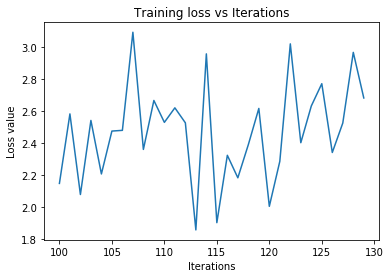

In [20]:
plt.plot(counter,loss_history)
plt.title("Training loss vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss value")

Text(0, 0.5, 'Loss value')

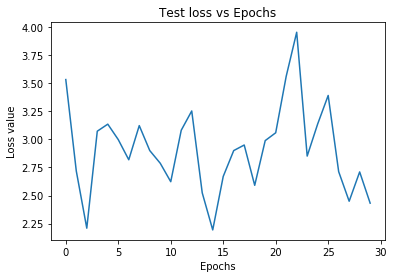

In [12]:
plt.plot(range(epoch+1),loss_history_t)
plt.title("Test loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss value")

### For training data

In [15]:
trial = list()

for i in range(0,5):
    trial.append(cnndataset[i])

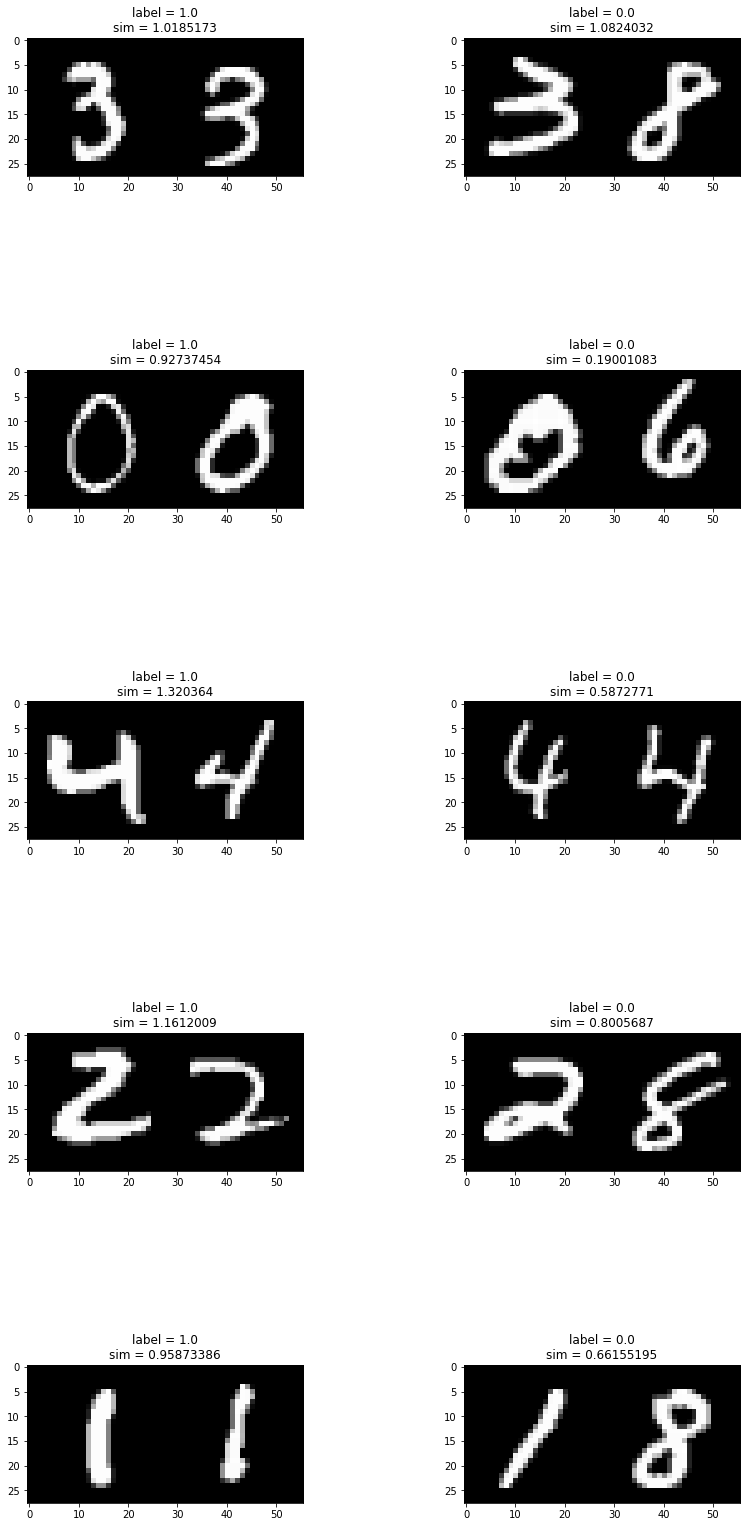

In [17]:
fig = plt.figure(1, figsize=(30,30))

i = 1 

for data in trial :

    im1, im2, lb1, im3, im4, lb2 = data

    diss1 = model.evaluate(im1,im2)
    diss2 = model.evaluate(im3,im4)
    
    im1 = np.concatenate((im1.numpy()[0],im2.numpy()[0]),axis=1)
    lb1 = lb1.numpy()
    
    im2 = np.concatenate((im3.numpy()[0],im4.numpy()[0]),axis=1)
    lb2 = lb2.numpy()
    
    diss1 = diss1.numpy()
    diss2 = diss2.numpy()

    ax1 = fig.add_subplot(10,4,i)
    ax1.title.set_text("label = "+str(lb1[0])+"\n"+"sim = "+str(diss1[0]))
    ax1.imshow(im1, cmap='gray')
    
    ax2 = fig.add_subplot(10,4,i+1)
    ax2.title.set_text("label = "+str(lb2[0])+"\n"+"sim = "+str(diss2[0]))
    ax2.imshow(im2, cmap='gray')

    i+=8

plt.show()

### For test data

In [18]:
trial_test = list()

for i in range(0,5):
    trial_test.append(cnndataset_test[i])

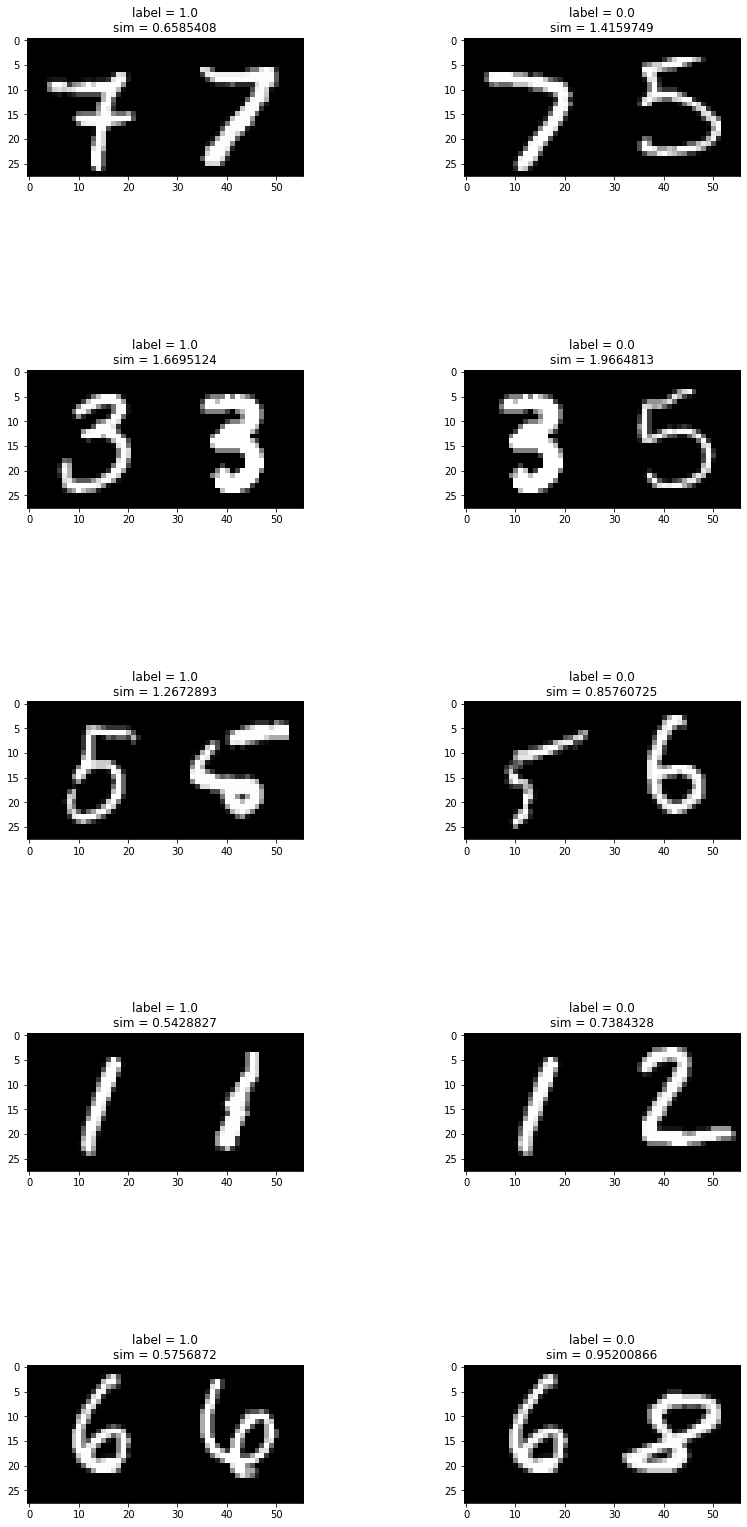

In [19]:
fig = plt.figure(1, figsize=(30,30))

i = 1 

for data in trial_test :

    im1, im2, lb1, im3, im4, lb2 = data

    diss1 = model.evaluate(im1,im2)
    diss2 = model.evaluate(im3,im4)
    im1 = np.concatenate((im1.numpy()[0],im2.numpy()[0]),axis=1)
    lb1 = lb1.numpy()
    
    im2 = np.concatenate((im3.numpy()[0],im4.numpy()[0]),axis=1)
    lb2 = lb2.numpy()
    
    diss1 = diss1.numpy()
    diss2 = diss2.numpy()

    ax1 = fig.add_subplot(10,4,i)
    ax1.title.set_text("label = "+str(lb1[0])+"\n"+"sim = "+str(diss1[0]))
    ax1.imshow(im1, cmap='gray')
    
    ax2 = fig.add_subplot(10,4,i+1)
    ax2.title.set_text("label = "+str(lb2[0])+"\n"+"sim = "+str(diss2[0]))
    ax2.imshow(im2, cmap='gray')

    i+=8

plt.show()